## Data preprocessing

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [43]:
""" data_path = "/home/onyx/Documents/MEMOIRE/memoire/data/sales_train_evaluation.csv"
pkl_path = "/home/onyx/Documents/MEMOIRE/memoire/data/sales_train_evaluation.pkl" """
data_path = "/home/onyx/Documents/Mémoire/memoire/data/sales_train_evaluation.csv"
pkl_path = "/home/onyx/Documents/Mémoire/memoire/data/sales_train_evaluation.pkl"

alpha = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99]

In [44]:
""" forecast_functions = [
    FC_avg_3_days,
    FC_avg_7_days,
    FC_avg_4_same_days
]

up_to_level_functions = [

]

safety_stock_functions = [

] """

' forecast_functions = [\n    FC_avg_3_days,\n    FC_avg_7_days,\n    FC_avg_4_same_days\n]\n\nup_to_level_functions = [\n\n]\n\nsafety_stock_functions = [\n\n] '

In [45]:
def load_data(csv_path: str, pkl_path: str) -> pd.DataFrame:
    """
    Load the CSV file, save it as a pickle file, and then reload it.
    
    Parameters:
        csv_path (str): Path to the CSV file.
        pkl_path (str): Path where the pickle file will be saved.
    
    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    df = pd.read_csv(csv_path)
    df.to_pickle(pkl_path)
    df = pd.read_pickle(pkl_path)
    return df

In [46]:
def scraping_high_zeroes_products(df: pd.DataFrame) -> pd.DataFrame:
    # Count the number of zeroes in each row
    df['zero_count'] = (df == 0).sum(axis=1)
    
    # Sort the DataFrame by the number of zeroes in ascending order
    df_sorted = df.sort_values(by='zero_count')
    
    # Keep only the top 1000 rows with the least number of zeroes
    df_top_2000 = df_sorted.head(1000)
    
    # Drop the 'zero_count' column as it is no longer needed
    df_top_2000 = df_top_2000.drop(columns=['zero_count'])
    
    return df_top_2000

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the DataFrame by removing unnecessary columns and converting
    the demand columns to numeric types.
    
    Parameters:
        df (pd.DataFrame): Original DataFrame.
    
    Returns:
        pd.DataFrame: Demand matrix with product 'id' as index and days as columns.
    """
    # Remove unnecessary columns
    df_demand = df.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
    # Set 'id' as index
    demand_matrix = df_demand.set_index('id')

    # Load the calendar.csv file
    calendar = pd.read_csv('/home/onyx/Documents/Mémoire/memoire/data/calendar.csv')

    # Get the date columns from the calendar dataframe
    date_columns = calendar['date']
    demand_matrix.columns = date_columns[0:demand_matrix.shape[1]]
    
    
    return demand_matrix

def analyse_data(df: pd.DataFrame) -> [pd.Series, pd.Series]:
    means = df.mean(axis=1)
    stds = df.std(axis=1)
    return means, stds



In [47]:
means = demand_matrix.mean(axis=1)
stds = demand_matrix.std(axis=1)

In [48]:
means, stds = analyse_data(demand_matrix)

inv_matrix = norm.ppf(0.95, means.values, stds.values)

datadddd = pd.DataFrame(
    np.ceil(np.repeat(inv_matrix[:, np.newaxis], demand_matrix.shape[1], axis=1)),
    columns=demand_matrix.columns,
    index=demand_matrix.index
)


In [49]:
""" df= load_data(data_path, pkl_path)
df2 = scraping_high_zeroes_products(df)
demand_matrix = preprocess_data(df2) """

' df= load_data(data_path, pkl_path)\ndf2 = scraping_high_zeroes_products(df)\ndemand_matrix = preprocess_data(df2) '

# Forecast Computing

Forecast computed on the average of the three lasts day sales

In [50]:
def FC_avg_3_days(demand_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the forecast by averaging the last 3 days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    forecast_matrix = demand_matrix.T.rolling(window=3).mean().shift(1).T
    return forecast_matrix

def FC_avg_7_days(demand_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the forecast by averaging the last 7 days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    forecast_matrix = demand_matrix.T.rolling(window=7).mean().shift(1).T
    return forecast_matrix

def FC_avg_30_days(demand_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the forecast by averaging the last 30 days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    forecast_matrix = demand_matrix.T.rolling(window=30).mean().shift(1).T
    return forecast_matrix

def FC_avg_4_same_days(demand_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the forecast by averaging the same day of the week over the previous 4 weeks for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Weekly forecast matrix (rounded up).
    """
    demand_np = demand_matrix.to_numpy()
    n_products, n_days = demand_np.shape
    weekly_forecast_np = np.full((n_products, n_days), np.nan)
    
    # For each day of the week (offset from 0 to 6)
    for offset in range(7):
        idx = np.arange(offset, n_days, 7)
        # Need at least 5 weeks to use the previous 4 weeks
        if len(idx) < 5:
            continue
        # Create a sliding window view for the previous 4 weeks
        slices = np.stack([demand_np[:, idx[i: i + len(idx) - 4]] for i in range(4)], axis=-1)
        rolling_mean = np.mean(slices, axis=-1)
        target_indices = idx[4:]  # Days to forecast
        weekly_forecast_np[:, target_indices] = rolling_mean
        
    weekly_forecast_matrix = pd.DataFrame(
        weekly_forecast_np,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return weekly_forecast_matrix

# Safety stock

In [51]:
def SS_cst(demand_matrix: pd.DataFrame, forecast_matrix: pd.DataFrame, safety_stock_value: int) -> pd.DataFrame:
    """
    Create a safety stock matrix with a constant integer value for each product and each day.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix with product index and days as columns.
        safety_stock_value (int): The safety stock level to assign.
    
    Returns:
        pd.DataFrame: Safety stock matrix with the same shape as demand_matrix, filled with safety_stock_value.
    """
    safety_stock_matrix = pd.DataFrame(
        safety_stock_value,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return safety_stock_matrix

def SS_on_forecast(demand_matrix: pd.DataFrame, forecast_matrix: pd.DataFrame, safety_stock_factor: int) -> pd.DataFrame:
    """
    Create a safety stock matrix constituted of the n+3 day of forecast times the safety_stock_factor.

    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix with product index and days as columns.
        safety_stock_factor: The factor to apply to the forecasted demand.

    Returns:
        pd.DataFrame: Safety stock matrix with the same shape as demand_matrix, filled with safety_stock_value.
    """
    safety_stock_matrix = pd.DataFrame(
        safety_stock_factor * forecast_matrix.shift(-3, axis=1).values,
        index=demand_matrix.index,
        columns=demand_matrix.columns
    )
    return safety_stock_matrix


# Up-to-level

In [52]:
""" df = load_data(data_path, pkl_path)
df = scraping_high_zeroes_products(df)
demand_matrix = preprocess_data(df)
test_df = demand_matrix.iloc[:5, :15] """

' df = load_data(data_path, pkl_path)\ndf = scraping_high_zeroes_products(df)\ndemand_matrix = preprocess_data(df)\ntest_df = demand_matrix.iloc[:5, :15] '

In [53]:
def up_to_level_optimal_restock(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate):
    """
    Find the optimal fixed restock level that reaches the minimal fill rate.
    
    Parameters:
        min_fill_rate (float): The minimum fill rate to achieve.
    
    Returns:
        int: The optimal fixed restock level.
    """
    demand = demand_matrix.to_numpy()
    up_to_level = np.ones(demand_matrix.shape)
    _, _, _, _, _, lost_sales = compute_stock(up_to_level, demand)
    fill_rates_per_product = compute_fill_rates_per_product(lost_sales, demand)

    while not (fill_rates_per_product > min_fill_rate).all():
        _, _, _, _, _, lost_sales = compute_stock(up_to_level, demand)
        fill_rates_per_product = compute_fill_rates_per_product(lost_sales, demand)
        goods = np.where(fill_rates_per_product <= min_fill_rate)
        up_to_level[goods] += 1
    
    
    return pd.DataFrame(up_to_level, index=demand_matrix.index, columns=demand_matrix.columns)

def compute_fill_rates_per_product(lost_sales, demand):
    """Compute the fill rate for each product
    
    Parameters:
        lost_sales (ndarray): Numpy array of lost sales.
        demand (ndarray): Numpy array of demand.
        
    Returns:
        ndarray: Numpy array of fill rates.
    """
    return 1 - lost_sales.sum(axis=1) / demand.sum(axis=1)
    

In [54]:
def up_to_level_3_next_days(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate):
    """
    Compute the forecast by summing the demand of the next 3 days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    up_to_level_matrix = forecast_matrix.T.shift(-2).rolling(window=3).sum().T
    return np.ceil(up_to_level_matrix)

def up_to_level_3_next_days_SS(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate):
    """
    Compute the forecast by summing the demand of the next 3 days for each product.
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
    
    Returns:
        pd.DataFrame: Forecast matrix (rounded up).
    """
    up_to_level_matrix = forecast_matrix.T.shift(-2).rolling(window=3).sum().T
    up_to_level_matrix += safety_stock_matrix
    return np.ceil(up_to_level_matrix)

def up_to_level_fixed_X(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate):
    ones = np.ones(demand_matrix.shape)
    up_to_level = ones * X
    up_to_level_matrix = pd.DataFrame(up_to_level, index=demand_matrix.index, columns=demand_matrix.columns)

    return up_to_level_matrix


In [55]:
def up_to_level_normal_demand(demand_matrix, forecast_matrix: pd.DataFrame, safety_stock_matrix: pd.DataFrame, X, min_fill_rate):
    
    means, stds = analyse_data(demand_matrix)

    inv_matrix = norm.ppf(0.95, means.values, stds.values)

    up_to_level_matrix = pd.DataFrame(
        np.ceil(np.repeat(inv_matrix[:, np.newaxis], demand_matrix.shape[1], axis=1)),
        columns=demand_matrix.columns,
        index=demand_matrix.index
        )
    
    return up_to_level_matrix


# Inventory

In [56]:
def compute_stock(up_to_level, demand):
    """
    Compute various stock management indicators:
      - inventory_begin: stock at the beginning of the day
      - inventory_end: stock at the end of the day
      - T1: stock transferred from the previous day
      - T2: additional stock needed to reach the forecasted level
      - sales: actual sales
      - lost_sales: unmet demand (lost sales)
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
        up_to_level_matrix (pd.DataFrame): Matrix of levels to reach.
        initial_inventory (int): Initial inventory at day 0.
    
    Returns:
        tuple of pd.DataFrame: DataFrames for inventory_begin, inventory_end, T1, T2, sales, and lost_sales.
    """

    """ # Conversion vers arrays
    demand = demand_matrix.to_numpy()
    up_to_level = up_to_level_matrix.to_numpy()
    # Ensure no NaN values in the matrices """
    np.nan_to_num(up_to_level, copy=False)

    n_products, n_days = demand.shape

    # Initialisation des arrays
    inventory_begin = np.zeros_like(demand)
    inventory_end = np.zeros_like(demand)
    T1 = np.zeros_like(demand)
    T2 = np.zeros_like(demand)
    sales = np.zeros_like(demand)
    lost_sales = np.zeros_like(demand)

    # Initialisation jour 0
    inventory_begin[:, 0] = 5
    T1[:, 0] = 0
    T2[:, 0] = up_to_level[:, 0] - inventory_begin[:, 0]
    inventory_end[:, 0] = np.maximum(inventory_begin[:, 0] - demand[:, 0], 0)
    sales[:, 0] = inventory_begin[:, 0] - inventory_end[:, 0]
    lost_sales[:, 0] = np.maximum(demand[:, 0] - sales[:, 0], 0)

    # Boucle vectorisée jour par jour
    for day in range(1, n_days):
        T1[:, day] = T2[:, day - 1]
        inventory_begin[:, day] = inventory_end[:, day - 1] + T1[:, day - 1]
        inventory_end[:, day] = np.maximum(inventory_begin[:, day] - demand[:, day], 0)
        T2[:, day] = np.nan_to_num(np.maximum(up_to_level[:, day] - inventory_end[:, day] - T1[:, day], 0))
        sales[:, day] = inventory_begin[:, day] - inventory_end[:, day]
        lost_sales[:, day] = np.maximum(demand[:, day] - sales[:, day], 0)

    """ # Reconvertir en DataFrames si besoin
    columns = demand_matrix.columns
    index = demand_matrix.index

    inventory_begin_matrix = pd.DataFrame(inventory_begin, index=index, columns=columns)
    inventory_end_matrix = pd.DataFrame(inventory_end, index=index, columns=columns)
    T1_matrix = pd.DataFrame(T1, index=index, columns=columns)
    T2_matrix = pd.DataFrame(T2, index=index, columns=columns)
    sales_matrix = pd.DataFrame(sales, index=index, columns=columns)
    lost_sales_matrix = pd.DataFrame(lost_sales, index=index, columns=columns) """

    return inventory_begin, inventory_end, T1, T2, sales, lost_sales

#inventory_begin, inventory_end, _, _, _, lost_sales = compute_stock(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy())


# Performance metrics

In [57]:
def compute_results(demand, lost_sales, inventory_begin, inventory_end, n_days):
    """
    Compute overall stock management metrics:
      - Fill rate
      - Average inventory
      - Ratio of days with perfect service (no lost sales)
    
    Parameters:
        demand_matrix (pd.DataFrame): Demand matrix.
        forecast_matrix (pd.DataFrame): Forecast matrix.
        up_to_level_matrix (pd.DataFrame): Matrix of levels to reach.
    
    Returns:
        dict: Dictionary containing the results.
    """

    fill_rate = 1 - lost_sales.sum().sum() / demand.sum().sum()
    avg_inventory = (inventory_begin.sum().sum() + inventory_end.sum().sum()) / 2 // n_days
    # Compute the average percentage of products containing lost sales per day
    products_with_lost_sales = (lost_sales > 0).sum(axis=0)/lost_sales.shape[0]
    average_percentage_lost_sales = products_with_lost_sales.mean()
    
    return fill_rate, avg_inventory, average_percentage_lost_sales

In [58]:
def compute_fill_rates_per_product(lost_sales, demand):
    """Compute the fill rate for each product
    
    Parameters:
        lost_sales (ndarray): Numpy array of lost sales.
        demand (ndarray): Numpy array of demand.
        
    Returns:
        ndarray: Numpy array of fill rates.
    """
    return 1 - lost_sales.sum(axis=1) / demand.sum(axis=1)

# Plots

In [59]:
def generate_plots(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end):
    
    # Transform in pd.DataFrame
    lost_sales_matrix = pd.DataFrame(lost_sales, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_begin_matrix = pd.DataFrame(inventory_begin, index=demand_matrix.index, columns=demand_matrix.columns)
    inventory_end_matrix = pd.DataFrame(inventory_end, index=demand_matrix.index, columns=demand_matrix.columns)

    # Scrap the first 7 days for the plot  
    demand_matrix = demand_matrix.iloc[:, 7:]
    forecast_matrix = forecast_matrix.iloc[:, 7:]
    lost_sales_matrix = lost_sales_matrix.iloc[:, 7:]
    inventory_begin_matrix = inventory_begin_matrix.iloc[:, 7:]
    inventory_end_matrix = inventory_end_matrix.iloc[:, 7:]
    
    # Agrégation
    total_demand = demand_matrix.sum(axis=0)
    total_forecast = forecast_matrix.sum(axis=0)
    total_inventory = (inventory_begin_matrix.sum(axis=0) + inventory_end_matrix.sum(axis=0)) / 2
    total_lost_sales = lost_sales_matrix.sum(axis=0)

    # Paramètres de style
    #plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(15, 6))

    # Tracés
    plt.plot(total_demand, label='Demand', color='dodgerblue', linewidth=1.5)
    plt.plot(total_forecast, label='Forecast', color='orangered', linewidth=1.5)
    plt.plot(total_lost_sales, label='Lost Sales', color='limegreen', linewidth=1.2)
    plt.plot(total_inventory, label='Average Inventory', color='saddlebrown', linewidth=1.5)

    # Améliorations visuelles
    plt.title('Daily Aggregated Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Units', fontsize=12)
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', labelsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right', frameon=True, framealpha=0.9)

    # Limiter les xticks pour lisibilité
    xtick_interval = 60  # afficher 1 tick tous les 60 jours
    plt.xticks(ticks=range(0, len(total_demand), xtick_interval),
            labels=total_demand.index[::xtick_interval], rotation=45)

    plt.tight_layout()
    plt.show()
    # Moyennes glissantes (7 jours)
    rolling_window = 7
    smoothed_demand = total_demand.rolling(window=rolling_window).mean()
    smoothed_forecast = total_forecast.rolling(window=rolling_window).mean()
    smoothed_inventory = total_inventory.rolling(window=rolling_window).mean()
    smoothed_lost_sales = total_lost_sales.rolling(window=rolling_window).mean()
    
    
    # Paramètres de style
    #plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(15, 6))

    # Tracés
    plt.plot(smoothed_demand, label='Demand (Smoothed)', color='dodgerblue')
    plt.plot(smoothed_forecast, label='Forecast (Smoothed)', color='orangered')
    plt.plot(smoothed_lost_sales, label='Lost Sales (Smoothed)', color='limegreen')
    plt.plot(smoothed_inventory, label='Avg Inventory (Smoothed)', color='saddlebrown')

    # Améliorations visuelles
    plt.title('Smoothed Metrics (7-Day Rolling)', fontsize=16, fontweight='bold')
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Units', fontsize=12)
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', labelsize=8)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right', frameon=True, framealpha=0.9)
    
    # Limiter les xticks pour lisibilité
    xtick_interval = 60  # afficher 1 tick tous les 60 jours
    plt.xticks(ticks=range(0, len(total_demand), xtick_interval),
            labels=total_demand.index[::xtick_interval], rotation=45)
    plt.tight_layout()
    plt.show()
    rolling_window = 7  # une semaine





In [60]:
def output(function_name: str, fill_rate: float, avg_inventory: float, ratio: float, output_csv: str):
    """
    Update or create a line in the output CSV file for the given function name with the provided metrics.
    
    Parameters:
        function_name (str): Name of the function.
        fill_rate (float): Fill rate value.
        avg_inventory (float): Average inventory value.
        ratio (float): Ratio of days with perfect service.
        output_csv (str): Path to the output CSV file.
    """
    # Load the existing CSV file or create a new DataFrame if it doesn't exist
    try:
        df_output = pd.read_csv(output_csv, index_col='Function Name')
    except FileNotFoundError:
        df_output = pd.DataFrame(columns=['Function Name', 'Fill Rate', 'Avg Inventory', 'Ratio'])
        df_output.set_index('Function Name', inplace=True)
    
    # Update or create the row for the given function name
    df_output.loc[function_name] = [fill_rate, avg_inventory, ratio]
    
    # Save the updated DataFrame back to the CSV file
    df_output.to_csv(output_csv)

# Example usage
output('FC_avg_2_days', 0.95, 1500, 0.85, 'output_metrics.csv')

# Pipeline


In [61]:
""" ### DEBUG CELL
df = load_data(data_path, pkl_path)
df = scraping_high_zeroes_products(df)
demand_matrix = preprocess_data(df)
#demand_matrix = demand_matrix.iloc[:1, :]# A RETIRER
_, n_days = demand_matrix.shape
forecast_matrix = FC_avg_3_days(demand_matrix)
safety_stock_matrix = SS_cst(demand_matrix, forecast_matrix, None)
up_to_level_matrix = up_to_level_3_next_days(demand_matrix, forecast_matrix, safety_stock_matrix, None, None)
inventory_begin, inventory_end, _, _, _, lost_sales = compute_stock(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy())
fill_rate, avg_inventory, average_percentage_lost_sales = compute_results(demand_matrix, lost_sales, inventory_begin, inventory_end, n_days) """

' ### DEBUG CELL\ndf = load_data(data_path, pkl_path)\ndf = scraping_high_zeroes_products(df)\ndemand_matrix = preprocess_data(df)\n#demand_matrix = demand_matrix.iloc[:1, :]# A RETIRER\n_, n_days = demand_matrix.shape\nforecast_matrix = FC_avg_3_days(demand_matrix)\nsafety_stock_matrix = SS_cst(demand_matrix, forecast_matrix, None)\nup_to_level_matrix = up_to_level_3_next_days(demand_matrix, forecast_matrix, safety_stock_matrix, None, None)\ninventory_begin, inventory_end, _, _, _, lost_sales = compute_stock(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy())\nfill_rate, avg_inventory, average_percentage_lost_sales = compute_results(demand_matrix, lost_sales, inventory_begin, inventory_end, n_days) '

In [62]:
def pipeline(forecast_func=None, 
             ss_func=None, ss_factor=None,
             up_to_level_func=None, X=None, min_fill_rate=None,
             compute_stock_func=None):
    df = load_data(data_path, pkl_path)
    df = scraping_high_zeroes_products(df)
    demand_matrix = preprocess_data(df)
    #demand_matrix = demand_matrix.iloc[:1, :]# A RETIRER
    _, n_days = demand_matrix.shape
    forecast_matrix = forecast_func(demand_matrix)
    safety_stock_matrix = ss_func(demand_matrix, forecast_matrix, ss_factor)
    up_to_level_matrix = up_to_level_func(demand_matrix, forecast_matrix, safety_stock_matrix, X, min_fill_rate)
    inventory_begin, inventory_end, _, _, _, lost_sales = compute_stock_func(up_to_level_matrix.to_numpy(), demand_matrix.to_numpy())
    fill_rate, avg_inventory, perfect_service_days_ratio = compute_results(demand_matrix, lost_sales, inventory_begin, inventory_end, n_days)

    generate_plots(demand_matrix, forecast_matrix, lost_sales, inventory_begin, inventory_end)

    print(f"Fill rate: {fill_rate * 100:.2f}%")
    print(f"Average inventory: {avg_inventory}")
    print(f"Average proportion of products not in stock: {perfect_service_days_ratio * 100:.2f}%")

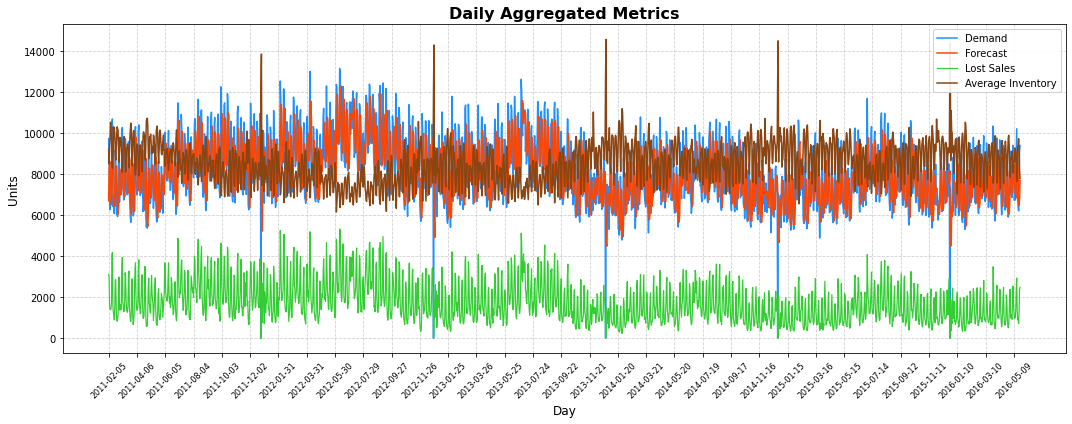

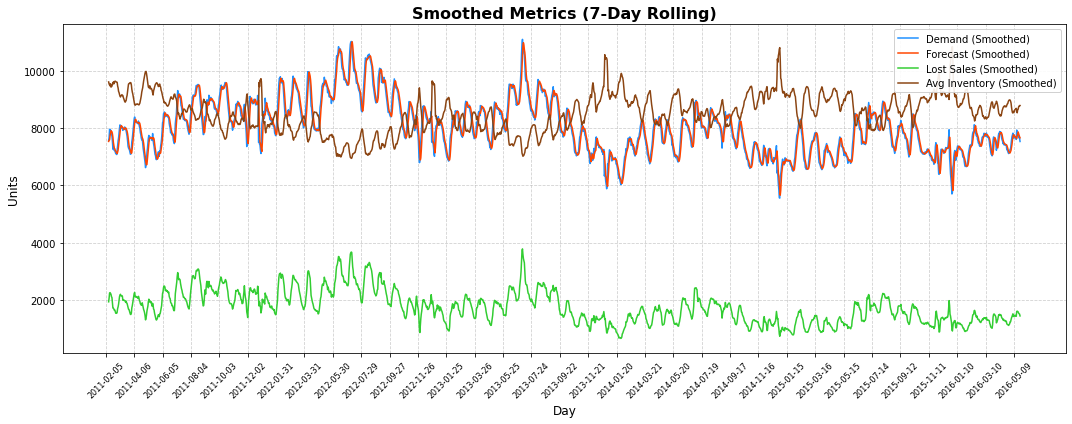

Fill rate: 78.18%
Average inventory: 8526.0
Average proportion of products not in stock: 25.81%


In [63]:
pipeline(forecast_func=FC_avg_3_days, 
         ss_func=SS_on_forecast, ss_factor=0.3,
         up_to_level_func=up_to_level_normal_demand, min_fill_rate=0.95,
         compute_stock_func=compute_stock)

moy de produit par jour en rupture sur la durée à tester